In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [74]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from numpy import matrix
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
lbar = cm[:,2]


snapshot=range(496,495,-1) #SNAPSHOTS
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value    
    vstr = snap['subhalo_000/Str/Velocities'].value
    
    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    mdrk = snap['subhalo_000/Drk/Masses'].value
    vdrk  = snap['subhalo_000/Drk/Velocities'].value
    
    pgas = snap['subhalo_000/Gas/Coordinates'].value
    mgas = snap['subhalo_000/Gas/Masses'].value
    vgas  = snap['subhalo_000/Gas/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)
    
    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2 + ydrk**2 + zdrk**2)
    
    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2 + ygas**2 + zgas**2)
    
#paso las velocidades a unidades físicas
    vstr_x = vstr[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    vstr_y = vstr[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    vstr_z = vstr[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
    
    vdrk_x = vdrk[:,0] *np.sqrt(aexp[isnap]) + Ht *xdrk/1000.
    vdrk_y = vdrk[:,1] *np.sqrt(aexp[isnap]) + Ht *ydrk/1000.
    vdrk_z = vdrk[:,2] *np.sqrt(aexp[isnap]) + Ht *zdrk/1000.
    
    vgas_x = vgas[:,0] *np.sqrt(aexp[isnap]) + Ht *xgas/1000.
    vgas_y = vgas[:,1] *np.sqrt(aexp[isnap]) + Ht *ygas/1000.
    vgas_z = vgas[:,2] *np.sqrt(aexp[isnap]) + Ht *zgas/1000.


#masa a unidades físicas
    mstr = mstr/h     
    mdrk = mdrk/h
    mgas = mgas/h
    
    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
    
    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)
    
    vstr_xcm = sum(mstr[veloc]*vstr_x[veloc])/sum(mstr[veloc])
    vstr_ycm = sum(mstr[veloc]*vstr_y[veloc])/sum(mstr[veloc])
    vstr_zcm = sum(mstr[veloc]*vstr_z[veloc])/sum(mstr[veloc])
    
    veloc2, = np.where(rdrk < r50)
    
    vdrk_xcm = sum(mdrk[veloc2]*vdrk_x[veloc2])/sum(mdrk[veloc2])
    vdrk_ycm = sum(mdrk[veloc2]*vdrk_y[veloc2])/sum(mdrk[veloc2])
    vdrk_zcm = sum(mdrk[veloc2]*vdrk_z[veloc2])/sum(mdrk[veloc2])
    
    veloc3, = np.where(rgas < r50)
    
    vgas_xcm = sum(mgas[veloc3]*vgas_x[veloc3])/sum(mgas[veloc3])
    vgas_ycm = sum(mgas[veloc3]*vgas_y[veloc3])/sum(mgas[veloc3])
    vgas_zcm = sum(mgas[veloc3]*vgas_z[veloc3])/sum(mgas[veloc3])


#velocidades de las estrellas respecto del centro de masa de la galaxia
    vstrx = vstr_x - vstr_xcm
    vstry = vstr_y - vstr_ycm
    vstrz = vstr_z - vstr_zcm
    
    vdrkx = vdrk_x - vdrk_xcm
    vdrky = vdrk_y - vdrk_ycm
    vdrkz = vdrk_z - vdrk_zcm
    
    vgasx = vgas_x - vgas_xcm
    vgasy = vgas_y - vgas_ycm
    vgasz = vgas_z - vgas_zcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular
#     if isnap == 496:
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vstrx,vstry,vstrz,2*r50)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn_str = e1x*vstrx + e1y*vstry + e1z*vstrz
    vyn_str = e2x*vstrx + e2y*vstry + e2z*vstrz
    vzn_str = e3x*vstrx + e3y*vstry + e3z*vstrz
    
    xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    vxn_drk = e1x*vdrkx + e1y*vdrky + e1z*vdrkz
    vyn_drk = e2x*vdrkx + e2y*vdrky + e2z*vdrkz
    vzn_drk = e3x*vdrkx + e3y*vdrky + e3z*vdrkz
    
    xn_gas = e1x*xgas + e1y*ygas + e1z*zgas
    yn_gas = e2x*xgas + e2y*ygas + e2z*zgas
    zn_gas = e3x*xgas + e3y*ygas + e3z*zgas
    vxn_gas = e1x*vgasx + e1y*vgasy + e1z*vgasz
    vyn_gas = e2x*vgasx + e2y*vgasy + e2z*vgasz
    vzn_gas = e3x*vgasx + e3y*vgasy + e3z*vgasz
    
#-------------------------------------------------------------------------------------- 
    lim_str,  = np.where(rstr < r200*1/3.)
    rstr_sort = np.sort(rstr[lim_str])
    rstr_ind  = np.argsort(rstr[lim_str])
    Mcum_str  = cumsum(mstr[lim_str][rstr_ind])
    
    lim_drk,  = np.where(rdrk < r200*1/3.)
    rdrk_sort = np.sort(rdrk[lim_drk])
    rdrk_ind  = np.argsort(rdrk[lim_drk])
    Mcum_drk  = cumsum(mdrk[lim_drk][rdrk_ind])
    
    lim_gas,  = np.where(rgas < r200*1/3.)
    rgas_sort = np.sort(rgas[lim_gas])
    rgas_ind  = np.argsort(rgas[lim_gas])
    Mcum_gas  = cumsum(mgas[lim_gas][rgas_ind])
    
#Calculamos las componentes de momento angular
    Lx_str = (yn_str*vzn_str - zn_str*vyn_str)
    Ly_str = (zn_str*vxn_str - xn_str*vzn_str)
    Lz_str = (xn_str*vyn_str - yn_str*vxn_str)
    
    Lx_str = Lx_str[lim_str][rstr_ind]
    Ly_str = Ly_str[lim_str][rstr_ind]
    Lz_str = Lz_str[lim_str][rstr_ind]
    
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    
    Lx_drk = (yn_drk*vzn_drk - zn_drk*vyn_drk)
    Ly_drk = (zn_drk*vxn_drk - xn_drk*vzn_drk)
    Lz_drk = (xn_drk*vyn_drk - yn_drk*vxn_drk)
    
    Lx_drk = Lx_drk[lim_drk][rdrk_ind]
    Ly_drk = Ly_drk[lim_drk][rdrk_ind]
    Lz_drk = Lz_drk[lim_drk][rdrk_ind]
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    Lx_gas = (yn_gas*vzn_gas - zn_gas*vyn_gas)
    Ly_gas = (zn_gas*vxn_gas - xn_gas*vzn_gas)
    Lz_gas = (xn_gas*vyn_gas - yn_gas*vxn_gas)
    
    Lx_gas = Lx_gas[lim_gas][rgas_ind]
    Ly_gas = Ly_gas[lim_gas][rgas_ind]
    Lz_gas = Lz_gas[lim_gas][rgas_ind]
    

#Guargamos los parámetros en distintos archivos
#-------------------------------------------------------------------------------------
    dd1 = np.ndarray([np.size(rstr_sort),5])
    dd1[:,0] = rstr_sort
    dd1[:,1] = Lx_str
    dd1[:,2] = Ly_str
    dd1[:,3] = Lz_str
    dd1[:,4] = Mcum_str
    np.savetxt('/home/ornela/python/barras/Lstr2_z=0.dat',dd1, 
               fmt=('%12.6f', '%12.6f', '%12.6f', '%12.6f', '%12.6f'))
    
    dd2 = np.ndarray([np.size(rdrk_sort),5])
    dd2[:,0] = rdrk_sort
    dd2[:,1] = Lx_drk
    dd2[:,2] = Ly_drk
    dd2[:,3] = Lz_drk
    dd2[:,4] = Mcum_drk
    np.savetxt('/home/ornela/python/barras/Ldrk2_z=0.dat',dd2, 
               fmt=('%12.6f', '%12.6f', '%12.6f', '%12.6f', '%12.6f'))
    
    dd3 = np.ndarray([np.size(rgas_sort),5])
    dd3[:,0] = rgas_sort
    dd3[:,1] = Lx_gas
    dd3[:,2] = Ly_gas
    dd3[:,3] = Lz_gas
    dd3[:,4] = Mcum_gas
    np.savetxt('/home/ornela/python/barras/Lgas2_z=0.dat',dd3,
               fmt=('%12.6f', '%12.6f', '%12.6f', '%12.6f', '%12.6f'))

    
#--------------------------------------------------------------------------------------
#el 2 es para r<r200*1/3.

In [26]:
print Mcum_str

[  3.02298827e-06   6.04597653e-06   9.06896457e-06 ...,   1.94863307e+00
   1.94863605e+00   1.94863904e+00]


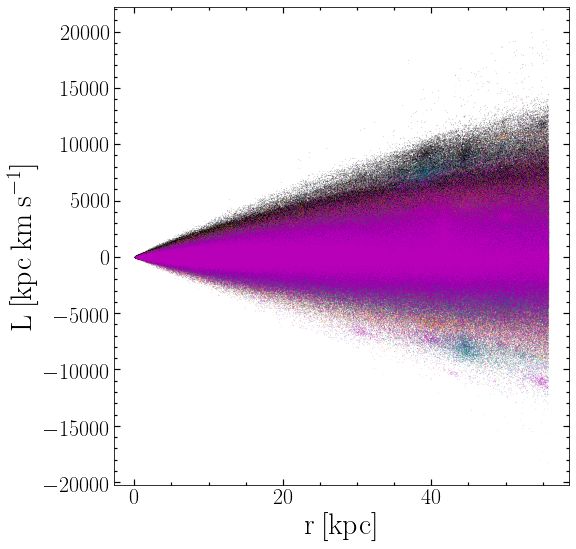

In [14]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm0 = np.loadtxt('/home/ornela/python/barras/Lstr2_z=0.dat')
r_str  = cm0[:,0]
Lx_str = cm0[:,1]
Ly_str = cm0[:,2]
Lz_str = cm0[:,3]
Mc_str = cm0[:,4]

cm1 = np.loadtxt('/home/ornela/python/barras/Ldrk2_z=0.dat')
r_drk  = cm1[:,0]
Lx_drk = cm1[:,1]
Ly_drk = cm1[:,2]
Lz_drk = cm1[:,3]

# cm2 = np.loadtxt('/home/ornela/python/barras/Lgas2_z=0.dat')
# r_gas  = cm2[:,0]
# Lx_gas = cm2[:,1]
# Ly_gas = cm2[:,2]
# Lz_gas = cm2[:,3]

# Lt_str = np.sqrt(Lx_str**2 + Ly_str**2 + Lz_str**2)

Lt_drk = np.sqrt(Lx_drk**2 + Ly_drk**2 + Lz_drk**2)

# Lt_gas = np.sqrt(Lx_gas**2 + Ly_gas**2 + Lz_gas**2)


fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
# ax.plot(r_gas,Lt_gas,'-', lw=2, color='k')
# ax.plot(r_gas,Lz_gas,'-', lw=2, color='darkorange')
# ax.plot(r_gas,Lx_gas,'-', lw=2, color='teal')
# ax.plot(r_gas,Ly_gas,'-', lw=2, color='m')

# ax.plot(r_str,Lt_str,'.', markersize=0.1, color='k')
# ax.plot(r_str,Lz_str,'.', markersize=0.1, color='darkorange')
# ax.plot(r_str,Mc_str,'k-',lw=2)
# ax.plot(r_str,Lx_str,'.', markersize=0.1, color='teal')
# ax.plot(r_str,Ly_str,'.', markersize=0.1, color='m')

ax.plot(r_drk,Lt_drk,'.', markersize=0.1, color='k')
ax.plot(r_drk,Lz_drk,'.', markersize=0.1, color='darkorange')
ax.plot(r_drk,Lx_drk,'.', markersize=0.1, color='teal')
ax.plot(r_drk,Ly_drk,'.', markersize=0.1, color='m')
# ax.set_xlim(7,14)
# ax.set_ylim(-1200,3600)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22)#, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$\rm{r\:[kpc]}$', fontsize=30)#, color='lightgray')
ax.set_ylabel(r'$\rm{L\:[kpc\:km\:s^{-1}]}$',fontsize=30)#, color='lightgray')
# ax.text(8,3000,'Estrellas', color='k', fontsize=30, ha='center')
# ax.text(8,2700,r'$\rm{L_{total}}$', color='k', fontsize=30, ha='center')
# ax.text(8,2400,r'$\rm{L_z}$', color='darkorange',fontsize=30, ha='center')
# ax.text(8,2100,r'$\rm{L_y}$', color='m', fontsize=30, ha='center')
# ax.text(8,1800,r'$\rm{L_x}$', color='teal', fontsize=30, ha='center')
plt.show()

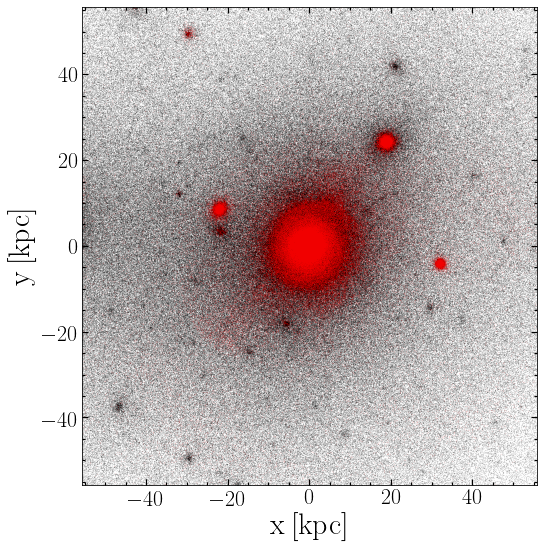

In [6]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from numpy import matrix
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
lbar = cm[:,2]


snapshot=range(496,495,-1) #SNAPSHOTS
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value    
    vstr = snap['subhalo_000/Str/Velocities'].value
    
    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    mdrk = snap['subhalo_000/Drk/Masses'].value
    vdrk  = snap['subhalo_000/Drk/Velocities'].value
    
    pgas = snap['subhalo_000/Gas/Coordinates'].value
    mgas = snap['subhalo_000/Gas/Masses'].value
    vgas  = snap['subhalo_000/Gas/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)
    
    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2 + ydrk**2 + zdrk**2)
    
    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2 + ygas**2 + zgas**2)
    
#paso las velocidades a unidades físicas
    vstr_x = vstr[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    vstr_y = vstr[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    vstr_z = vstr[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
    
    vdrk_x = vdrk[:,0] *np.sqrt(aexp[isnap]) + Ht *xdrk/1000.
    vdrk_y = vdrk[:,1] *np.sqrt(aexp[isnap]) + Ht *ydrk/1000.
    vdrk_z = vdrk[:,2] *np.sqrt(aexp[isnap]) + Ht *zdrk/1000.
    
    vgas_x = vgas[:,0] *np.sqrt(aexp[isnap]) + Ht *xgas/1000.
    vgas_y = vgas[:,1] *np.sqrt(aexp[isnap]) + Ht *ygas/1000.
    vgas_z = vgas[:,2] *np.sqrt(aexp[isnap]) + Ht *zgas/1000.


#masa a unidades físicas
    mstr = mstr/h     
    mdrk = mdrk/h
    mgas = mgas/h
    
    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
    
    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)
    
    vstr_xcm = sum(mstr[veloc]*vstr_x[veloc])/sum(mstr[veloc])
    vstr_ycm = sum(mstr[veloc]*vstr_y[veloc])/sum(mstr[veloc])
    vstr_zcm = sum(mstr[veloc]*vstr_z[veloc])/sum(mstr[veloc])
    
    veloc2, = np.where(rdrk < r50)
    
    vdrk_xcm = sum(mdrk[veloc2]*vdrk_x[veloc2])/sum(mdrk[veloc2])
    vdrk_ycm = sum(mdrk[veloc2]*vdrk_y[veloc2])/sum(mdrk[veloc2])
    vdrk_zcm = sum(mdrk[veloc2]*vdrk_z[veloc2])/sum(mdrk[veloc2])
    
    veloc3, = np.where(rgas < r50)
    
    vgas_xcm = sum(mgas[veloc3]*vgas_x[veloc3])/sum(mgas[veloc3])
    vgas_ycm = sum(mgas[veloc3]*vgas_y[veloc3])/sum(mgas[veloc3])
    vgas_zcm = sum(mgas[veloc3]*vgas_z[veloc3])/sum(mgas[veloc3])


#velocidades de las estrellas respecto del centro de masa de la galaxia
    vstrx = vstr_x - vstr_xcm
    vstry = vstr_y - vstr_ycm
    vstrz = vstr_z - vstr_zcm
    
    vdrkx = vdrk_x - vdrk_xcm
    vdrky = vdrk_y - vdrk_ycm
    vdrkz = vdrk_z - vdrk_zcm
    
    vgasx = vgas_x - vgas_xcm
    vgasy = vgas_y - vgas_ycm
    vgasz = vgas_z - vgas_zcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular
#     if isnap == 496:
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vstrx,vstry,vstrz,2*r50)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn_str = e1x*vstrx + e1y*vstry + e1z*vstrz
    vyn_str = e2x*vstrx + e2y*vstry + e2z*vstrz
    vzn_str = e3x*vstrx + e3y*vstry + e3z*vstrz
    
    xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    vxn_drk = e1x*vdrkx + e1y*vdrky + e1z*vdrkz
    vyn_drk = e2x*vdrkx + e2y*vdrky + e2z*vdrkz
    vzn_drk = e3x*vdrkx + e3y*vdrky + e3z*vdrkz
    
    xn_gas = e1x*xgas + e1y*ygas + e1z*zgas
    yn_gas = e2x*xgas + e2y*ygas + e2z*zgas
    zn_gas = e3x*xgas + e3y*ygas + e3z*zgas
    vxn_gas = e1x*vgasx + e1y*vgasy + e1z*vgasz
    vyn_gas = e2x*vgasx + e2y*vgasy + e2z*vgasz
    vzn_gas = e3x*vgasx + e3y*vgasy + e3z*vgasz
    
    lim = r200*1/3.
#---------------------------------------------------------------------------------------
    fig=plt.figure(1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax=fig.add_subplot(111)
    ax.plot(xn_drk,yn_drk,'.', markersize=0.05, color='k')
    #ax.plot(xn_gas,yn_gas,'.', markersize=0.1, color='b')
    ax.plot(xn_str,yn_str,'.', markersize=0.05, color='r')
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
#     ax.spines['bottom'].set_color('w')
#     ax.spines['top'].set_color('w')
#     ax.spines['left'].set_color('w')
#     ax.spines['right'].set_color('w')
    ax.minorticks_on()
    ax.tick_params( labelsize=22)#, colors='lightgray')
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
#     ax.set_facecolor('silver')
#     ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    ax.set_xlabel(r'$\rm{x\:[kpc]}$', fontsize=30)#, color='lightgray')
    ax.set_ylabel(r'$\rm{y\:[kpc]}$',fontsize=30)#, color='lightgray')
    plt.show()

In [72]:
print r200*1/3

55.7367941712


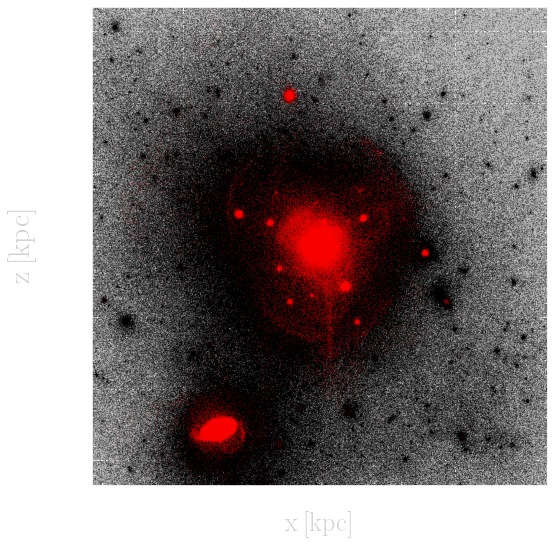

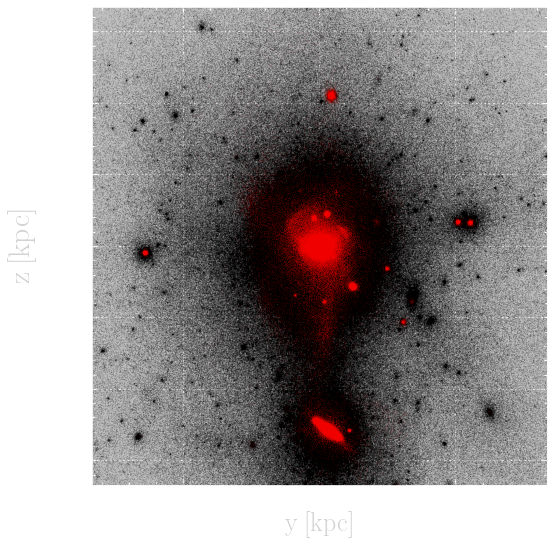

In [66]:
# import sphviewer as sph
# rl=20
# pos=np.ndarray([3,np.size(xn_str)])
# pos[0,:]=xn_str
# pos[1,:]=yn_str
# pos[2,:]=zn_str

# particles=sph.Particles(pos,mstr*1e10)
# escena=sph.Scene(particles)
# escena.update_camera(r='infinity',x=-75,y=10,z=-130,extent=[-rl,rl,-rl,rl])
# rend=sph.Render(escena)
# extent=escena.get_extent()
# rend.set_logscale()



fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
# plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap='gnuplot', vmin=1, vmax= 7)
ax.plot(xn_drk,zn_drk,'.', markersize=0.1, color='k')
#ax.plot(xn_gas,zn_gas,'.', markersize=0.1, color='b')
ax.plot(xn_str,zn_str,'.', markersize=0.1, color='r')
ax.set_xlim(-r200,r200)
ax.set_ylim(-r200,r200)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$\rm{x\:[kpc]}$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$\rm{z\:[kpc]}$',fontsize=30, color='lightgray')
plt.show()


fig=plt.figure(2, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(yn_drk,zn_drk,'.', markersize=0.05, color='k')
#ax.plot(yn_gas,zn_gas,'.', markersize=0.1, color='b')
ax.plot(yn_str,zn_str,'.', markersize=0.05, color='r')
ax.set_xlim(-r200,r200)
ax.set_ylim(-r200,r200)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$\rm{y\:[kpc]}$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$\rm{z\:[kpc]}$',fontsize=30, color='lightgray')
plt.show()